## Creating Birdman plots HCC Data
Date: 8/2/2024
Taken from: https://github.com/ahdilmore/MARS_Birdman/blob/main/birdman/zebra_birdman_analysis.ipynb
  
conda env: comad

#### Imports

In [1]:
import pandas as pd
import qiime2 as q2
import numpy as np
import biom

# plotting 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
data_dict = {
    'blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter': 'micov_blood_HCC_v_CRC/inferences-results/blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter.beta_var.tsv',
}
vars_to_check = {
    'blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter' : 'tumor_type[T.HCC]_'
}

#### Functions

In [3]:
def read_results(p):
    return pd.read_csv(p, sep='\t', index_col='Feature')

def unpack_hdi_and_filter(df, col):
    #HDI: High Density Interval -- highest density interval of posterial distributions
    #This is also known as the minimum width Bayesian credible interval
    #https://python.arviz.org/en/stable/api/generated/arviz.hdi.html --> package for how this was calcualted
    #also in other scripts where Hazel added this (was not the default from Gibs)
    #Reason for adding is a lot of the means have insane std. dev. and so this is giving us a full range
    #and allowing us to remove things that have 0 in thier range
    
    #This comes in a string so subsetting it
    df[['lower', 'upper']] = df[col].str.split(',', expand=True)
    # remove ( from lower and ) from upper and convert to float 
    df.lower = df.lower.str[1:].astype('float')
    df.upper = df.upper.str[:-1].astype('float')
    
    #Drop any interval where 0 is in the interval because then clearly not a strong indicater
    df['credible'] = np.where((df.lower > 0) | (df.upper < 0), 'yes', 'no')
    
    #This is used just to plot the lines before and after the dots
    df.upper = df.upper - df[col.replace('hdi', 'mean')]
    df.lower = df[col.replace('hdi', 'mean')] - df.lower
    
    return df

In [4]:
def display_top_n_feats(fn, df, n, yvar, xvar, xlab, ylab, title):
    #n : displays the top and bottom n if there are more than n features
    
    if df.shape[0] < 2*n: 
        df_for_display = df 
    else: 
        bottomn = df[:n]
        topn = df[-1*n:]
        df_for_display = pd.concat([bottomn, topn])
    
    '''
    sns.stripplot(data=df_for_display, y=yvar, x=xvar, ax=ax)
    plt.errorbar(data=df_for_display, 
                 x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    '''
    # Set your desired figure size (adjust width and height as needed)
    fig, ax = plt.subplots(figsize=(17, 7))

    # Create strip plot
    sns.stripplot(data=df_for_display, y=yvar, x=xvar, ax=ax)

    # Add error bars
    plt.errorbar(data=df_for_display, x=xvar, y=yvar,
                 xerr=df_for_display[['lower', 'upper']].T, ls='none')

    # Set labels and title
    plt.ylabel(ylab)
    plt.xlabel(xlab)
    plt.title(title)
    
    plt.tight_layout()
    
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
    plt.rcParams['svg.fonttype'] = 'none'  # render SVG text as text, not curves
    
    plt.savefig('figures/' + fn + '.svg')
    plt.show()
    
    display(df_for_display)
    print(list(df_for_display['Feature']))
    
    df_for_display.to_csv('figures/' + fn + '.tsv', sep='\t', index =False)
    

In [5]:
#Create RS210 taxanomy into a useable dic 
rs210 = pd.read_csv('/scratch/qp-woltka/RS210/RS210.tax', sep='\t', header=None, index_col=0)
rs210_dict = rs210[1].to_dict() 

def add_taxonomy_col_rs210(df):
    
    # Convert gOTUS into readable taxonomy
    df['Taxonomy'] = df['Feature'].map(rs210_dict)
    
    #Create label with gOTU and taxonomu
    df['gOTU_Taxonomy'] = df['Feature'] + ' : ' + df['Taxonomy']


#### Code

In [8]:
# update names 
for k in data_dict.keys():
    df = read_results(data_dict[k])
    for v in vars_to_check: 
        if v in k: 
            var = vars_to_check[v] 
    print(k)
    print('Unfiltered Shape:  ' + str(df.shape))
    sub_df = unpack_hdi_and_filter(df, var+'hdi')
    print('Filtered Shape: ' + str(sub_df.loc[sub_df['credible'] == 'yes'].shape))
    sub_df.rename_axis(index='Feature', inplace=True)
    
    data_dict[k] = sub_df.sort_values(by=var+'mean')

blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter
Unfiltered Shape:  (469, 6)
Filtered Shape: (44, 9)


#### Plotting

tumor_type[T.HCC]_


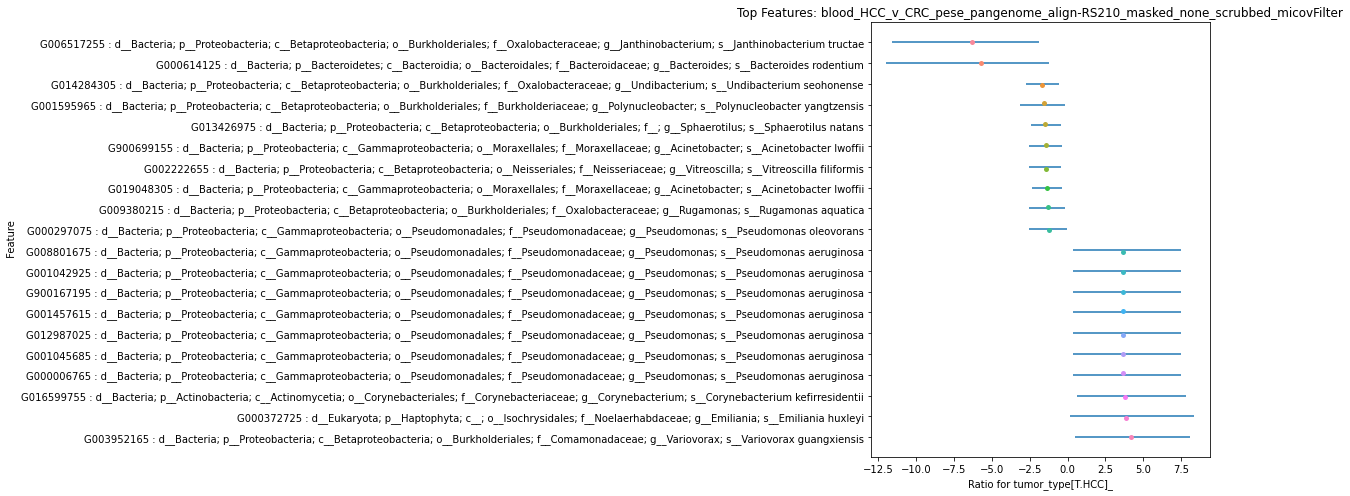

,Feature,Intercept_mean,tumor_type[T.HCC]_mean,Intercept_std,tumor_type[T.HCC]_std,Intercept_hdi,tumor_type[T.HCC]_hdi,lower,upper,credible,Taxonomy,gOTU_Taxonomy
0,G006517255,-6.362416,-6.330512,0.548063,2.669070,"(-7.40161, -5.41246)","(-11.608, -1.90985)",5.277488,4.420662,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G006517255 : d__Bacteria; p__Proteobacteria; c...
1,G000614125,-7.451849,-5.709143,0.911971,2.999945,"(-9.14372, -5.85791)","(-11.9643, -1.19543)",6.255157,4.513713,yes,d__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,G000614125 : d__Bacteria; p__Bacteroidetes; c_...
41,G014284305,-5.265889,-1.656227,0.411924,0.574977,"(-6.06486, -4.51287)","(-2.77595, -0.555149)",1.119723,1.101078,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G014284305 : d__Bacteria; p__Proteobacteria; c...
46,G001595965,-5.252740,-1.543181,0.633919,0.778835,"(-6.38302, -4.0413)","(-3.11125, -0.169216)",1.568069,1.373965,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G001595965 : d__Bacteria; p__Proteobacteria; c...
50,G013426975,-5.887358,-1.492236,0.405992,0.538250,"(-6.66581, -5.13528)","(-2.42615, -0.437776)",0.933914,1.054460,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G013426975 : d__Bacteria; p__Proteobacteria; c...
51,G900699155,-6.044786,-1.433978,0.442080,0.577593,"(-6.85503, -5.22772)","(-2.56978, -0.391494)",1.135802,1.042484,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G900699155 : d__Bacteria; p__Proteobacteria; c...
52,G002222655,-5.143007,-1.425077,0.430869,0.569482,"(-5.89624, -4.27597)","(-2.56692, -0.434881)",1.141843,0.990196,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G002222655 : d__Bacteria; p__Proteobacteria; c...
54,G019048305,-5.888100,-1.363869,0.395691,0.518013,"(-6.6208, -5.17084)","(-2.35453, -0.396761)",0.990661,0.967108,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G019048305 : d__Bacteria; p__Proteobacteria; c...
57,G009380215,-6.070385,-1.299333,0.470379,0.603159,"(-6.96915, -5.20222)","(-2.54604, -0.198231)",1.246707,1.101102,yes,d__Bacteria; p__Proteobacteria; c__Betaproteob...,G009380215 : d__Bacteria; p__Proteobacteria; c...
58,G000297075,-6.310192,-1.253481,0.522616,0.675038,"(-7.29558, -5.35374)","(-2.51597, -0.0316286)",1.262489,1.221852,yes,d__Bacteria; p__Proteobacteria; c__Gammaproteo...,G000297075 : d__Bacteria; p__Proteobacteria; c...


['G006517255', 'G000614125', 'G014284305', 'G001595965', 'G013426975', 'G900699155', 'G002222655', 'G019048305', 'G009380215', 'G000297075', 'G008801675', 'G001042925', 'G900167195', 'G001457615', 'G012987025', 'G001045685', 'G000006765', 'G016599755', 'G000372725', 'G003952165']


In [9]:
for k in data_dict.keys(): 
    for v in vars_to_check.keys(): 
        if v in k:
            print(var)
            xlab = 'Ratio for ' + var
            var = vars_to_check[v]
    
    ylab = ' Feature'
    df_for_display = data_dict[k].reset_index()
    df_for_display = df_for_display.loc[df_for_display.credible == 'yes']

    add_taxonomy_col_rs210(df_for_display)

    display_top_n_feats('blood_HCC_v_CRC_pese_pangenome_align-RS210_masked_none_scrubbed_micovFilter',df_for_display, 10, 'gOTU_Taxonomy', var+'mean', xlab, ylab,'Top Features: ' + k)